# Analysis of the Relationship Between Loads and Temperatures by BA


In [91]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


## Set the Directory Structure

In [67]:
# Identify the top-level directory and the subdirectory where the data will be stored:
load_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/tell_output/'
met_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/wrf_to_tell_data/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_tbd/data/divergence/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_tbd/figures/Balancing_Authorities/'


## Process the Annual Mean Load Difference

In [75]:
# Define a function to process the time-series of loads and temperatures for a given BA
def process_ba_load_temperature_time_series(load_data_input_dir: str, met_data_input_dir: str, scenario: str, year: str, ba: str):
    # Read in the BA-level time series the scenario and year:
    load_df = pd.read_csv(load_data_input_dir + scenario + '/' + year + '/TELL_Balancing_Authority_Hourly_Load_Data_' + year + '_Scaled_' + year + '.csv')
    
    # Rename a few columns for simplicity:
    load_df.rename(columns={'BA_Code': 'BA', 'Scaled_TELL_BA_Load_MWh': 'Load_MWh'}, inplace=True)
        
    # Only keep the columns that are needed:
    load_df = load_df[['BA', 'Time_UTC', 'Load_MWh']].copy()
        
    # Subset to just the BA being processed:
    load_df = load_df[load_df['BA'] == ba]
    
    # Read in the BA-level meteorology time series the scenario and year:
    met_df = pd.read_csv(met_data_input_dir + scenario + '/' + ba + '_WRF_Hourly_Mean_Meteorology_' + year + '.csv')
    
    # Only keep the columns that are needed:
    met_df = met_df[['Time_UTC', 'T2']].copy()
    
    # Merge the two time series together on time:
    merged_df = load_df.merge(met_df, on=['Time_UTC'])
        
    return merged_df
        

In [92]:
df = process_ba_load_temperature_time_series(load_data_input_dir = load_data_input_dir, 
                                             met_data_input_dir = met_data_input_dir, 
                                             scenario = 'rcp85hotter_ssp5', 
                                             year = '2080',
                                             ba = 'CISO')

df


102


,T2,Mean_Load_MWh
1,43.5,71809.88
2,44.5,71827.81
3,45.5,71847.96
4,46.5,71910.34
5,47.5,72015.28
6,48.5,72138.16
7,49.5,72327.76
8,50.5,72516.45
9,51.5,72783.04
10,52.5,73056.55


## Make the Plots

In [147]:
# Define a function to plot the time series for a single BA:
def plot_ba_load_temperature_relationship(load_data_input_dir: str, met_data_input_dir: str, scenario: str, year: str, ba: str, 
                                          image_output_dir: str, image_resolution: int, save_images=False):
    
    # Merge the load and meteorology data together:
    df = process_ba_load_temperature_time_series(load_data_input_dir = load_data_input_dir, 
                                                met_data_input_dir = met_data_input_dir, 
                                                scenario = scenario, 
                                                year = year,
                                                ba = ba)
    
    # Convert temperatures from K to F:
    df['T2'] = ((df['T2'] - 273.15) * (9/5)) + 32
    
    # Find the minimum and maximum temperatures:
    t_min = df['T2'].min().round(0).astype(int)
    t_max = df['T2'].max().round(0).astype(int)

    #Initiate a counter and empty dataframe to store the results:
    counter = 0;
    stats_df = pd.DataFrame()

    # Loop over the temperatures and compute the mean load in each temperature bin:
    for t in range(t_min, t_max, 1):
        # Iterate the counter by one:
        counter = counter + 1 
    
        # Put the statistics in a new dataframe:
        stats_df.loc[counter, 'T2'] = (t + 0.5)

        # Subset the data to just the T2 values in a given bin and compute the corresponding mean load:
        subset_df = df.loc[(df['T2'] >= t) & (df['T2'] <= (t+1))]
        if subset_df.empty == False:
           stats_df.loc[counter, 'Mean_Load_MWh'] = subset_df['Load_MWh'].mean().round(2)
        else:
           stats_df.loc[counter, 'Mean_Load_MWh'] = np.nan
        del subset_df
       
    # Loop over the temperature bins and compute the change in load from the previous bin:
    for i in range(1, len(stats_df)):
        stats_df.loc[i, 'Load_Delta_MWh'] = abs(stats_df.iloc[i]['Mean_Load_MWh'].copy() - stats_df.iloc[i-1]['Mean_Load_MWh'].copy())
    
    # Compute the relative load change:
    stats_df['Load_Delta_%'] = 100*(stats_df['Load_Delta_MWh']/stats_df['Mean_Load_MWh']).round(4)
        
    # Make the plot:
    plt.figure(figsize=(15, 8))
    plt.rcParams['font.size'] = 14
    plt.scatter(df['T2'], df['Load_MWh'], s=10, c='k')
    plt.plot(stats_df['T2'], stats_df['Mean_Load_MWh'], 'r', linewidth=3, label=('Average slope = ' + str(stats_df['Load_Delta_%'].mean().round(2)) + '% per 1$^\circ$F'))
    plt.grid(True)
    plt.legend(loc='upper left', prop={'size': 14})
    plt.xlabel('Hourly Temperature [$^\circ$F]');
    plt.ylabel('Hourly Load [MWh]')
    plt.title(('Temperature Load Relationship: ' + ba + ', ' + scenario + ', ' + year))
     
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('BA_T_Load_Relationships_' + ba + '_' + scenario + '_' + year + '.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
       #plt.close()


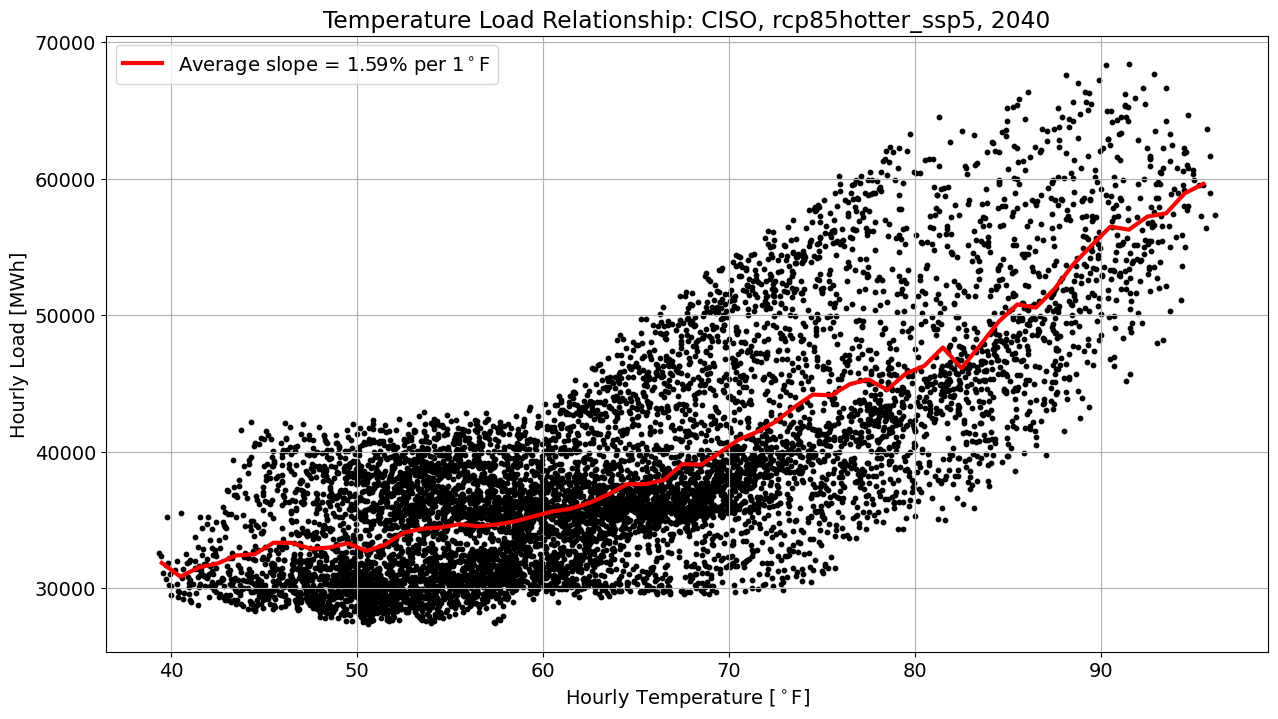

In [148]:
plot_ba_load_temperature_relationship(load_data_input_dir = load_data_input_dir, 
                                      met_data_input_dir = met_data_input_dir, 
                                      scenario = 'rcp85hotter_ssp5', 
                                      year = '2040',
                                      ba = 'CISO',
                                      image_output_dir = image_output_dir,
                                      image_resolution = 300,
                                      save_images = True)
